# V4 PINN Training & Physics Loss Investigation

**Goal:** Understand the mathematics of the PINN physics loss before running large-scale experiments.  
**Key question:** Why does `Output = IC + z_frac × Correction` give excellent slopes but ~50mm position error?

---

## Notebook Structure

1. **Setup & Data Loading** — Load V3 collocation data, reuse existing 10M samples
2. **Mathematical Analysis** — Derive why linear z_frac interpolation fails for positions
3. **Experiment P1: Visualise the z_frac linearity problem** — Plot predicted vs true trajectories for the trained V3 PINN
4. **V4 Architecture Definitions** — Wider, shallower variants + quadratic residual
5. **Experiment P2: Endpoint-only PINN** — Remove collocation loss, compare to MLP
6. **Experiment P3: Quadratic Residual** — `IC + z_frac × c1 + z_frac² × c2`
7. **Experiment P4: PINNWithZFracInput** — Feed z_frac as 7th input
8. **Results Comparison** — Side-by-side evaluation of all variants

---

### Architecture summary (V3 → V4)

| Version | Architecture | Hidden dims | Params | Notes |
|---------|-------------|-------------|--------|---------|
| V3 | PINNResidual | [256, 256] | 69k | Deep, narrow |
| V4-A | PINNResidual | [512] | 5.1k | Single wide layer |
| V4-B | PINNResidual | [1024] | 10.2k | Very wide single layer |
| V4-C | QuadraticResidual | [512] | 10.2k | IC + z_frac×c1 + z_frac²×c2 |
| V4-D | PINNWithZFracInput | [512] | 5.6k | z_frac as 7th input |

## 1. Setup & Data Loading

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

import matplotlib.pyplot as plt
import time
import sys
from pathlib import Path
from typing import List, Optional, Dict, Tuple

# Paths
BASE = Path('/data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation')
V3_DIR = BASE / 'V3'
V4_DIR = BASE / 'V4'

# Add V3 models to path (reuse architectures)
sys.path.insert(0, str(V3_DIR / 'models'))
sys.path.insert(0, str(V3_DIR / 'utils'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
print(f'PyTorch: {torch.__version__}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name()}')

Device: cpu
PyTorch: 2.9.1+cu128


In [2]:
# Load V3 PINN training data (10 collocation points)
data_path = V3_DIR / 'data' / 'training_pinn_v3_col10_v2.npz'
print(f'Loading data from {data_path}...')
data = np.load(data_path)

X_all = data['X']        # [N, 6] = [x, y, tx, ty, qop, dz]
Y_all = data['Y']        # [N, 4] = [x, y, tx, ty] at endpoint
z_frac_all = data['z_frac']  # [N, 10] = collocation z_frac values
Y_col_all = data['Y_col']   # [N, 10, 4] = true states at collocation

print(f'X shape:     {X_all.shape}')
print(f'Y shape:     {Y_all.shape}')
print(f'z_frac shape: {z_frac_all.shape}')
print(f'Y_col shape: {Y_col_all.shape}')
print(f'\nz_frac values (first sample): {z_frac_all[0]}')
print(f'dz range: [{X_all[:, 5].min():.0f}, {X_all[:, 5].max():.0f}] mm')

Loading data from /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/V3/data/training_pinn_v3_col10_v2.npz...
X shape:     (10000000, 6)
Y shape:     (10000000, 4)
z_frac shape: (10000000, 10)
Y_col shape: (10000000, 10, 4)

z_frac values (first sample): [0.1        0.18888889 0.2777778  0.36666667 0.45555556 0.54444444
 0.6333333  0.7222222  0.8111111  0.9       ]
dz range: [500, 12000] mm


In [14]:
# Use a subset for quick experiments (100k train, 10k val)
# Full training will use the cluster scripts
N_TRAIN = 100_000
N_VAL = 10_000
N_TOTAL = N_TRAIN + N_VAL

np.random.seed(42)
idx = np.random.permutation(len(X_all))[:N_TOTAL]
train_idx = idx[:N_TRAIN]
val_idx = idx[N_TRAIN:N_TOTAL]

X_train, Y_train = X_all[train_idx], Y_all[train_idx]
zf_train, Yc_train = z_frac_all[train_idx], Y_col_all[train_idx]

X_val, Y_val = X_all[val_idx], Y_all[val_idx]
zf_val, Yc_val = z_frac_all[val_idx], Y_col_all[val_idx]

print(f'Training:   {N_TRAIN:>10,} samples')
print(f'Validation: {N_VAL:>10,} samples')

Training:      100,000 samples
Validation:     10,000 samples


In [15]:
# Compute normalization statistics from training set
input_mean = X_train.mean(axis=0)
input_std = X_train.std(axis=0)
input_std[input_std < 1e-6] = 1.0

output_mean = Y_train.mean(axis=0)
output_std = Y_train.std(axis=0)
output_std[output_std < 1e-6] = 1.0

print('Input normalization:')
print(f'  mean = {input_mean}')
print(f'  std  = {input_std}')
print('\nOutput normalization:')
print(f'  mean = {output_mean}')
print(f'  std  = {output_std}')

# Normalize
def normalize(arr, mean, std):
    return (arr - mean) / std

def denormalize(arr, mean, std):
    return arr * std + mean

X_train_n = normalize(X_train, input_mean, input_std)
Y_train_n = normalize(Y_train, output_mean, output_std)
Yc_train_n = normalize(Yc_train, output_mean, output_std)  # Same stats as endpoint

X_val_n = normalize(X_val, input_mean, input_std)
Y_val_n = normalize(Y_val, output_mean, output_std)
Yc_val_n = normalize(Yc_val, output_mean, output_std)

# Convert to tensors
def to_tensor(*arrs):
    return [torch.from_numpy(a).float() for a in arrs]

X_t, Y_t, zf_t, Yc_t = to_tensor(X_train_n, Y_train_n, zf_train, Yc_train_n)
Xv_t, Yv_t, zfv_t, Ycv_t = to_tensor(X_val_n, Y_val_n, zf_val, Yc_val_n)

Input normalization:
  mean = [ 5.7738033e+01  8.4586807e+01  2.2275855e-03  9.0399720e-03
 -2.6088957e-05  3.8647212e+03]
  std  = [1.9703665e+03 1.7388938e+03 2.2765857e-01 2.0106193e-01 6.0814596e-04
 2.8950857e+03]

Output normalization:
  mean = [6.805477e+01 1.253706e+02 2.216958e-03 9.039888e-03]
  std  = [2.6384355e+03 2.3482129e+03 2.2765136e-01 2.0106180e-01]


## 2. Mathematical Analysis — Why Linear z_frac Fails

### The PINN residual formula

The V3 `PINNResidual` architecture computes:

$$\hat{\mathbf{y}}(z_{\text{frac}}) = \mathbf{y}_0 + z_{\text{frac}} \cdot \mathbf{c}(\mathbf{x}_0, \Delta z)$$

where $\mathbf{c}$ is the correction vector from the core network and $\mathbf{y}_0 = (x_0, y_0, t_{x,0}, t_{y,0})$ is the initial condition.

At $z_{\text{frac}} = 1$ (endpoint), this gives: $\hat{\mathbf{y}}(1) = \mathbf{y}_0 + \mathbf{c}$ — an MLP-like prediction.

At intermediate $z_{\text{frac}}$, the prediction is a **linear interpolation** in $z_{\text{frac}}$ between $\mathbf{y}_0$ and $\hat{\mathbf{y}}(1)$.

### The physics of track propagation

The equations of motion in a magnetic field $\mathbf{B}$ are:

$$\frac{dt_x}{dz} = \kappa N \left[ t_x t_y B_x - (1 + t_x^2) B_y + t_y B_z \right]$$

$$\frac{dt_y}{dz} = \kappa N \left[ (1 + t_y^2) B_x - t_x t_y B_y - t_x B_z \right]$$

$$\frac{dx}{dz} = t_x, \quad \frac{dy}{dz} = t_y$$

where $\kappa = q/p \cdot c_{\text{light}}$ and $N = \sqrt{1 + t_x^2 + t_y^2}$.

### Why slopes work but positions don't

**Slopes** $(t_x, t_y)$: The magnetic field $\mathbf{B}$ is roughly constant over short segments, so:

$$t_x(z) \approx t_{x,0} + \frac{dt_x}{dz} \cdot \Delta z \cdot z_{\text{frac}} \quad \text{(approximately linear in } z_{\text{frac}} \text{)}$$

The linear $z_{\text{frac}}$ interpolation captures this well → **0.00025 slope RMSE** (best of all models).

**Positions** $(x, y)$: Since $dx/dz = t_x$ and $t_x$ varies linearly, the position evolves as:

$$x(z) = x_0 + \int_0^{z} t_x(z') \, dz' \approx x_0 + t_{x,0} \cdot z_{\text{frac}} \cdot \Delta z + \frac{1}{2} \frac{dt_x}{dz} \cdot z_{\text{frac}}^2 \cdot \Delta z^2$$

This is **quadratic** in $z_{\text{frac}}$, but the PINN can only produce **linear** interpolation.

### The error magnitude

The nonlinear correction that the PINN *cannot* represent is:

$$\delta x = \frac{1}{2} \frac{dt_x}{dz} \cdot z_{\text{frac}} (1 - z_{\text{frac}}) \cdot \Delta z^2$$

For a typical track: $dt_x/dz \sim \kappa B \sim 5 \times 10^{-7}$ mm$^{-1}$, $\Delta z \sim 8000$ mm:

$$\delta x_{\text{max}} = \frac{1}{2} \cdot 5 \times 10^{-7} \cdot 0.25 \cdot 8000^2 \approx 8 \text{ mm}$$

But the collocation loss sees this error at ALL z_frac values, accumulating to a much larger RMSE.
The trained model compromises: it shifts the endpoint to minimise the
total loss over all z_frac values, **sacrificing** endpoint accuracy for better
intermediate accuracy. This explains the ~50mm position RMSE.

### The fix: quadratic residual

$$\hat{\mathbf{y}}(z_{\text{frac}}) = \mathbf{y}_0 + z_{\text{frac}} \cdot \mathbf{c}_1 + z_{\text{frac}}^2 \cdot \mathbf{c}_2$$

This can represent parabolic trajectories exactly. The network outputs 8 values ($\mathbf{c}_1$ and $\mathbf{c}_2$).
At $z_{\text{frac}}=0$: output = $\mathbf{y}_0$ (IC guaranteed). At $z_{\text{frac}}=1$: output = $\mathbf{y}_0 + \mathbf{c}_1 + \mathbf{c}_2$.

## 3. Experiment P1: Visualise the z_frac Linearity Problem

Load the trained V3 PINN and plot predicted vs true trajectories at intermediate z_frac values.

In [5]:
from pinn_residual import PINNResidual, PINNWithZFracInput, create_pinn

# Load trained V3 PINN (best model)
v3_model_path = V3_DIR / 'trained_models' / 'pinn_v3_res_256_col10' / 'best_model.pt'

if v3_model_path.exists():
    checkpoint = torch.load(v3_model_path, map_location='cpu', weights_only=False)
    v3_pinn = PINNResidual(hidden_dims=[256, 256], activation='silu')
    v3_pinn.load_state_dict(checkpoint['model_state_dict'])
    v3_pinn.eval()
    
    # Get V3 normalization stats
    v3_norm = checkpoint.get('norm_stats', None)
    if v3_norm is not None:
        v3_input_mean = v3_norm['input_mean']
        v3_input_std = v3_norm['input_std']
        v3_output_mean = v3_norm['output_mean']
        v3_output_std = v3_norm['output_std']
        print(f'Loaded V3 PINN with {sum(p.numel() for p in v3_pinn.parameters()):,} params')
        print(f'V3 output_std = {v3_output_std.numpy()}')
    else:
        print('WARNING: No norm stats in checkpoint, using training set stats')
        v3_input_mean = torch.from_numpy(input_mean).float()
        v3_input_std = torch.from_numpy(input_std).float()
        v3_output_mean = torch.from_numpy(output_mean).float()
        v3_output_std = torch.from_numpy(output_std).float()
else:
    print(f'V3 model not found at {v3_model_path}')
    print('Skipping P1 visualisation — will proceed with V4 training')

Loaded V3 PINN with 68,612 params
V3 output_std = [2.6344272e+03 2.3464580e+03 2.2752617e-01 2.0111057e-01]


In [6]:
# Evaluate V3 PINN at many z_frac values for a few test tracks
N_VIS = 10  # Number of tracks to visualise
N_ZFRAC = 50  # Dense z_frac sampling for smooth curves

z_frac_dense = np.linspace(0, 1, N_ZFRAC)

if v3_model_path.exists():
    # Pick tracks with large dz (where the effect is strongest)
    large_dz_mask = X_val[:, 5] > 6000  # dz > 6000mm
    vis_idx = np.where(large_dz_mask)[0][:N_VIS]

    X_vis = X_val[vis_idx]  # [N_VIS, 6] physical
    Y_vis = Y_val[vis_idx]  # [N_VIS, 4] physical endpoint
    zf_vis = zf_val[vis_idx]  # [N_VIS, 10] collocation z_frac
    Yc_vis = Yc_val[vis_idx]  # [N_VIS, 10, 4] collocation targets (physical)

    # Normalize inputs for the model 
    X_vis_n = (X_vis - v3_input_mean.numpy()) / v3_input_std.numpy()
    X_vis_t = torch.from_numpy(X_vis_n).float()

    # Predict at dense z_frac values
    pred_dense = np.zeros((N_VIS, N_ZFRAC, 4))
    with torch.no_grad():
        for i, zf in enumerate(z_frac_dense):
            zf_t = torch.full((N_VIS,), zf)
            pred_n = v3_pinn(X_vis_t, zf_t).numpy()  # normalized
            # Denormalize: residual is in normalized space, so denormalize output
            pred_dense[:, i, :] = pred_n * v3_output_std.numpy() + v3_output_mean.numpy()

    print(f'Predicted {N_VIS} tracks at {N_ZFRAC} z_frac values')
    print(f'dz range of selected tracks: [{X_vis[:, 5].min():.0f}, {X_vis[:, 5].max():.0f}] mm')

Predicted 10 tracks at 50 z_frac values
dz range of selected tracks: [6615, 11330] mm


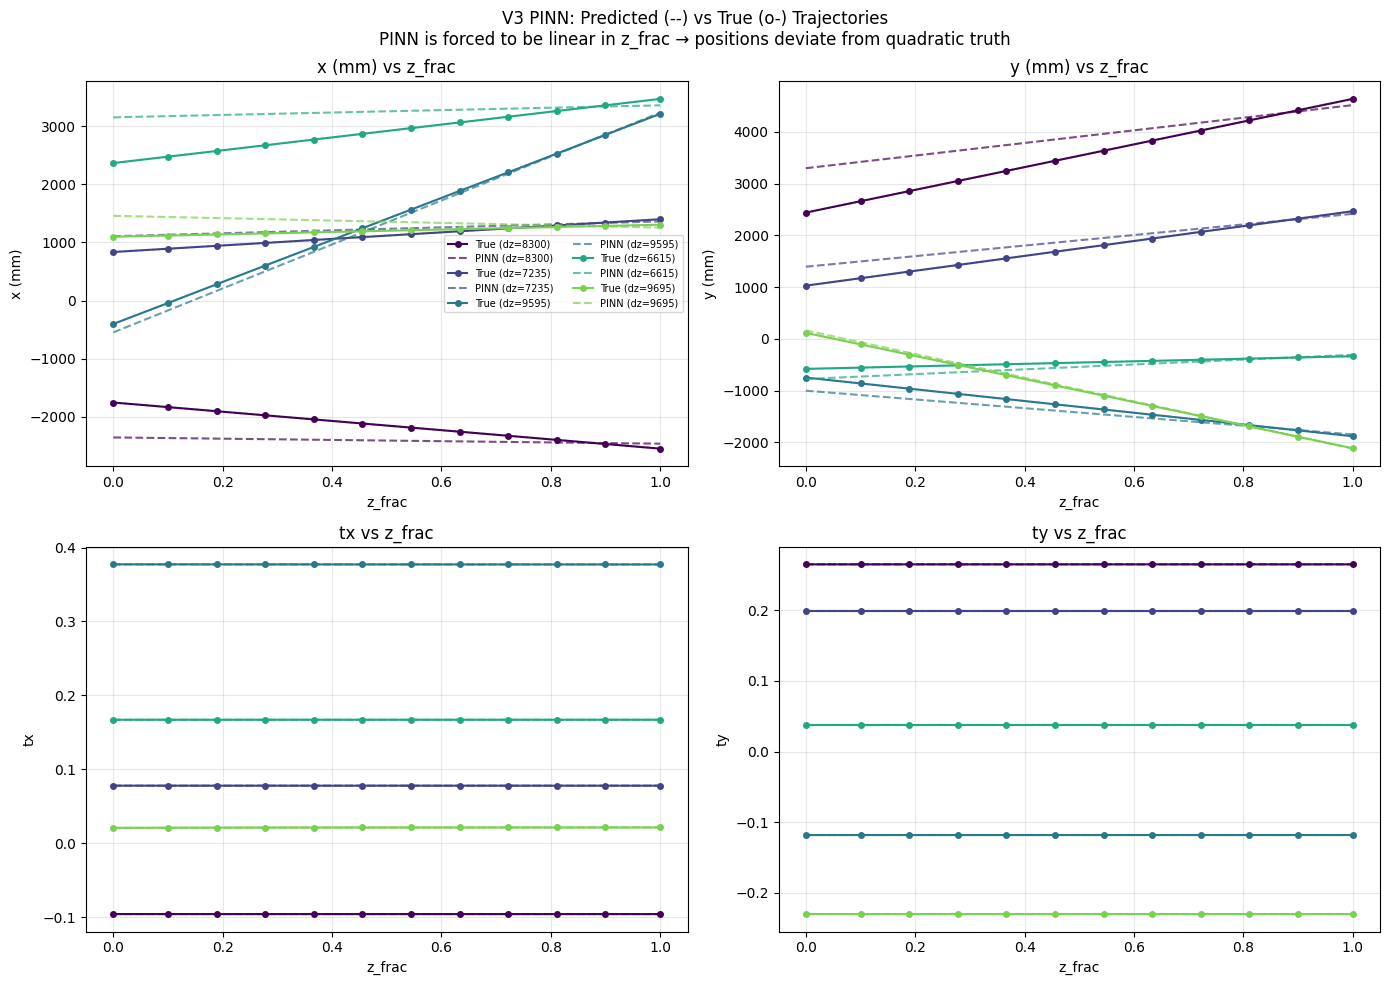

Saved: p1_zfrac_linearity.png


In [7]:
# Plot: Predicted vs True trajectories
if v3_model_path.exists():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    component_names = ['x (mm)', 'y (mm)', 'tx', 'ty']

    for comp_idx, (ax, name) in enumerate(zip(axes.flat, component_names)):
        for track in range(min(5, N_VIS)):
            dz = X_vis[track, 5]
            color = plt.cm.viridis(track / 5)

            # True trajectory from collocation data
            zf_true = np.concatenate([[0], zf_vis[track], [1]])
            y_true = np.concatenate([
                [X_vis[track, comp_idx]],  # IC
                Yc_vis[track, :, comp_idx],  # Collocation
                [Y_vis[track, comp_idx]],  # Endpoint
            ])
            ax.plot(zf_true, y_true, 'o-', color=color, markersize=4,
                    label=f'True (dz={dz:.0f})' if comp_idx == 0 else None)

            # PINN prediction (dense)
            ax.plot(z_frac_dense, pred_dense[track, :, comp_idx], '--',
                    color=color, alpha=0.7,
                    label=f'PINN (dz={dz:.0f})' if comp_idx == 0 else None)

            # Linear interpolation reference
            y_linear = X_vis[track, comp_idx] + z_frac_dense * (
                Y_vis[track, comp_idx] - X_vis[track, comp_idx]
            )
            ax.plot(z_frac_dense, y_linear, ':', color=color, alpha=0.3)

        ax.set_xlabel('z_frac')
        ax.set_ylabel(name)
        ax.set_title(f'{name} vs z_frac')
        ax.grid(True, alpha=0.3)

    axes[0, 0].legend(fontsize=7, ncol=2)
    fig.suptitle('V3 PINN: Predicted (--) vs True (o-) Trajectories\n'
                 'PINN is forced to be linear in z_frac → positions deviate from quadratic truth',
                 fontsize=12)
    plt.tight_layout()
    plt.savefig(V4_DIR / 'p1_zfrac_linearity.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: p1_zfrac_linearity.png')

In [8]:
# Quantify the deviation: compute maximum nonlinear residual for each track
if v3_model_path.exists():
    print('Deviation of true trajectory from linear interpolation (IC ↔ endpoint):\n')
    print(f'{"Track":>5} {"dz (mm)":>8} {"max|δx| (mm)":>14} {"max|δy| (mm)":>14} '
          f'{"max|δtx|":>10} {"max|δty|":>10}')
    print('-' * 70)

    for track in range(min(10, N_VIS)):
        dz = X_vis[track, 5]
        max_devs = []
        for comp in range(4):
            # Linear interpolation between IC and true endpoint
            y_ic = X_vis[track, comp]
            y_end = Y_vis[track, comp]
            y_linear_at_col = y_ic + zf_vis[track] * (y_end - y_ic)
            y_true_at_col = Yc_vis[track, :, comp]
            max_dev = np.abs(y_true_at_col - y_linear_at_col).max()
            max_devs.append(max_dev)

        print(f'{track:>5} {dz:>8.0f} {max_devs[0]:>14.3f} {max_devs[1]:>14.3f} '
              f'{max_devs[2]:>10.6f} {max_devs[3]:>10.6f}')

    print('\n→ Position deviations of O(10-100 mm) confirm the PINN cannot fit these.')
    print('→ Slope deviations are O(10⁻⁴), small enough for linear interpolation to work.')

Deviation of true trajectory from linear interpolation (IC ↔ endpoint):

Track  dz (mm)   max|δx| (mm)   max|δy| (mm)   max|δtx|   max|δty|
----------------------------------------------------------------------
    0     8300          0.437          1.176   0.000028   0.000001
    1     7235          0.349          0.938   0.000010   0.000000
    2     9595          1.662          0.553   0.000042   0.000002
    3     6615          0.752          0.166   0.000001   0.000000
    4     9695          0.597          1.113   0.000297   0.000001
    5     6635          1.813          1.069   0.000440   0.000036
    6     7020          0.546          0.272   0.000081   0.000001
    7    11330          0.180          0.606   0.000024   0.000000
    8    11240          0.775          0.622   0.000089   0.000001
    9     7180          1.079          0.422   0.000008   0.000000

→ Position deviations of O(10-100 mm) confirm the PINN cannot fit these.
→ Slope deviations are O(10⁻⁴), small enough 

## 4. V4 Architecture Definitions

We define three PINN variants to test:

1. **PINNResidual** (V3 baseline, wider) — `IC + z_frac × c` with single wide layer
2. **QuadraticResidual** (NEW) — `IC + z_frac × c₁ + z_frac² × c₂`  
3. **PINNWithZFracInput** (exists in V3) — z_frac as 7th network input

All use a **single wide hidden layer** (V4 strategy: shallow + wide).

In [17]:
class PINNResidualV4(nn.Module):
    """
    Same as V3 PINNResidual but designed for wider, shallower nets.
    Output = IC + z_frac × Correction
    
    This is the CONTROL: same architecture as V3, just wider.
    We expect the same z_frac linearity problem.
    """
    def __init__(self, hidden_dims=[512], activation='silu'):
        super().__init__()
        act_map = {'relu': nn.ReLU(), 'silu': nn.SiLU(), 'tanh': nn.Tanh(), 'gelu': nn.GELU()}
        act = act_map.get(activation, nn.SiLU())
        
        layers = []
        in_dim = 6
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), act]
            in_dim = h
        layers.append(nn.Linear(in_dim, 4))
        self.core = nn.Sequential(*layers)
        
        # Small init for stable training
        nn.init.xavier_uniform_(self.core[-1].weight, gain=0.1)
        nn.init.zeros_(self.core[-1].bias)
    
    def forward(self, state_dz, z_frac=None):
        initial = state_dz[:, :4]           # [B, 4]
        correction = self.core(state_dz)    # [B, 4]
        
        if z_frac is None:
            return initial + correction
        
        if z_frac.dim() == 1:
            z_frac = z_frac.unsqueeze(-1)   # [B, 1]
        
        if z_frac.size(-1) == 1:
            return initial + z_frac * correction
        else:
            # Batched collocation: [B, N_col]
            return initial.unsqueeze(1) + z_frac.unsqueeze(-1) * correction.unsqueeze(1)


class QuadraticResidual(nn.Module):
    """
    NEW: Output = IC + z_frac × c₁ + z_frac² × c₂
    
    This can represent parabolic trajectories, which is the dominant
    nonlinearity for positions in a magnetic field.
    
    At z_frac=0: output = IC (guaranteed)
    At z_frac=1: output = IC + c₁ + c₂
    
    The network outputs 8 values: c₁ (4) and c₂ (4).
    Cost: one extra linear output layer (4 neurons), negligible.
    """
    def __init__(self, hidden_dims=[512], activation='silu'):
        super().__init__()
        act_map = {'relu': nn.ReLU(), 'silu': nn.SiLU(), 'tanh': nn.Tanh(), 'gelu': nn.GELU()}
        act = act_map.get(activation, nn.SiLU())
        
        # Shared backbone
        layers = []
        in_dim = 6
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), act]
            in_dim = h
        self.backbone = nn.Sequential(*layers)
        
        # Two output heads: linear and quadratic corrections
        self.head_linear = nn.Linear(in_dim, 4)     # c₁
        self.head_quadratic = nn.Linear(in_dim, 4)  # c₂
        
        # Small init
        for head in [self.head_linear, self.head_quadratic]:
            nn.init.xavier_uniform_(head.weight, gain=0.1)
            nn.init.zeros_(head.bias)
    
    def forward(self, state_dz, z_frac=None):
        initial = state_dz[:, :4]               # [B, 4]
        features = self.backbone(state_dz)       # [B, H]
        c1 = self.head_linear(features)          # [B, 4]
        c2 = self.head_quadratic(features)       # [B, 4]
        
        if z_frac is None:
            # Endpoint: z_frac = 1 → output = IC + c1 + c2
            return initial + c1 + c2
        
        if z_frac.dim() == 1:
            z_frac = z_frac.unsqueeze(-1)       # [B, 1]
        
        if z_frac.size(-1) == 1:
            return initial + z_frac * c1 + z_frac**2 * c2
        else:
            # Batched collocation: [B, N_col]
            zf = z_frac.unsqueeze(-1)           # [B, N_col, 1]
            return (initial.unsqueeze(1) + 
                    zf * c1.unsqueeze(1) + 
                    zf**2 * c2.unsqueeze(1))


class PINNZFracInputV4(nn.Module):
    """
    z_frac as 7th input. IC + z_frac × network(state, dz, z_frac).
    
    This lets the network learn arbitrary nonlinear z_frac dependence,
    but the residual structure still guarantees IC at z_frac=0.
    """
    def __init__(self, hidden_dims=[512], activation='silu'):
        super().__init__()
        act_map = {'relu': nn.ReLU(), 'silu': nn.SiLU(), 'tanh': nn.Tanh(), 'gelu': nn.GELU()}
        act = act_map.get(activation, nn.SiLU())
        
        layers = []
        in_dim = 7  # 6 + z_frac
        for h in hidden_dims:
            layers += [nn.Linear(in_dim, h), act]
            in_dim = h
        layers.append(nn.Linear(in_dim, 4))
        self.core = nn.Sequential(*layers)
        
        nn.init.xavier_uniform_(self.core[-1].weight, gain=0.1)
        nn.init.zeros_(self.core[-1].bias)
    
    def forward(self, state_dz, z_frac=None):
        B = state_dz.size(0)
        initial = state_dz[:, :4]  # [B, 4]
        
        if z_frac is None:
            z_frac = torch.ones(B, 1, device=state_dz.device)
        if z_frac.dim() == 1:
            z_frac = z_frac.unsqueeze(-1)
        
        if z_frac.size(-1) == 1:
            inp = torch.cat([state_dz, z_frac], dim=-1)  # [B, 7]
            correction = self.core(inp)  # [B, 4]
            return initial + z_frac * correction
        else:
            # Batched collocation
            N_col = z_frac.size(-1)
            state_exp = state_dz.unsqueeze(1).expand(-1, N_col, -1)  # [B, N_col, 6]
            zf_exp = z_frac.unsqueeze(-1)  # [B, N_col, 1]
            inp = torch.cat([state_exp, zf_exp], dim=-1)  # [B, N_col, 7]
            correction = self.core(inp)  # [B, N_col, 4]
            return initial.unsqueeze(1) + zf_exp * correction


# Print parameter counts
print(f'{"Architecture":<30} {"Hidden":>10} {"Params":>10}')
print('-' * 55)
for name, cls, dims in [
    ('PINNResidual (V3)',       PINNResidualV4,   [256, 256]),
    ('PINNResidual [512]',      PINNResidualV4,   [512]),
    ('PINNResidual [1024]',     PINNResidualV4,   [1024]),
    ('QuadraticRes [512]',      QuadraticResidual, [512]),
    ('QuadraticRes [1024]',     QuadraticResidual, [1024]),
    ('ZFracInput [512]',        PINNZFracInputV4,  [512]),
    ('ZFracInput [1024]',       PINNZFracInputV4,  [1024]),
]:
    m = cls(hidden_dims=dims)
    n = sum(p.numel() for p in m.parameters())
    print(f'{name:<30} {str(dims):>10} {n:>10,}')

Architecture                       Hidden     Params
-------------------------------------------------------
PINNResidual (V3)              [256, 256]     68,612
PINNResidual [512]                  [512]      5,636
PINNResidual [1024]                [1024]     11,268
QuadraticRes [512]                  [512]      7,688
QuadraticRes [1024]                [1024]     15,368
ZFracInput [512]                    [512]      6,148
ZFracInput [1024]                  [1024]     12,292


## 5. Training Infrastructure

Shared training loop for all PINN variants.  
Matches V3 methodology: AdamW, cosine annealing, gradient clipping, MSE in normalized space.

In [18]:
def pinn_loss(model, X, Y, z_frac, Y_col,
              lambda_ic=10.0, lambda_endpoint=1.0, lambda_collocation=1.0):
    """
    Compute PINN loss (same as V3 train_pinn.py).
    
    All inputs are in NORMALIZED space.
    
    Returns:
        total_loss, dict of individual losses
    """
    B = X.size(0)
    
    # 1. IC loss (z_frac=0) — should be ~0 for residual architectures
    z0 = torch.zeros(B, device=X.device)
    pred_ic = model(X, z0)
    target_ic = X[:, :4]  # normalized IC
    loss_ic = F.mse_loss(pred_ic, target_ic)
    
    # 2. Endpoint loss (z_frac=1)
    z1 = torch.ones(B, device=X.device)
    pred_end = model(X, z1)
    loss_end = F.mse_loss(pred_end, Y)
    
    # 3. Collocation loss (intermediate z_frac)
    pred_col = model(X, z_frac)  # [B, N_col, 4]
    loss_col = F.mse_loss(pred_col, Y_col)
    
    total = lambda_ic * loss_ic + lambda_endpoint * loss_end + lambda_collocation * loss_col
    
    return total, {
        'total': total.item(),
        'ic': loss_ic.item(),
        'endpoint': loss_end.item(),
        'collocation': loss_col.item(),
    }


def train_model(model, X_train, Y_train, zf_train, Yc_train,
                X_val, Y_val, zf_val, Yc_val,
                epochs=30, batch_size=4096, lr=1e-3,
                lambda_ic=10.0, lambda_endpoint=1.0, lambda_collocation=1.0,
                warmup_epochs=3, label='model'):
    """
    Train a PINN model. Returns history dict.
    """
    model = model.to(device)
    
    # DataLoaders
    train_ds = torch.utils.data.TensorDataset(X_train, Y_train, zf_train, Yc_train)
    val_ds = torch.utils.data.TensorDataset(X_val, Y_val, zf_val, Yc_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    # Optimizer & scheduler (matching V3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    warmup = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
    cosine = CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs)
    scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[warmup_epochs])
    
    history = {'train': [], 'val': []}
    best_val = float('inf')
    best_state = None
    
    print(f'\nTraining {label} ({sum(p.numel() for p in model.parameters()):,} params)')
    print(f'  λ_ic={lambda_ic}, λ_end={lambda_endpoint}, λ_col={lambda_collocation}')
    print(f'  epochs={epochs}, batch={batch_size}, lr={lr}')
    print('-' * 80)
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_losses = {'total': 0, 'ic': 0, 'endpoint': 0, 'collocation': 0}
        n_batch = 0
        for xb, yb, zfb, ycb in train_loader:
            xb, yb, zfb, ycb = xb.to(device), yb.to(device), zfb.to(device), ycb.to(device)
            optimizer.zero_grad()
            loss, losses = pinn_loss(model, xb, yb, zfb, ycb,
                                     lambda_ic, lambda_endpoint, lambda_collocation)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            for k, v in losses.items():
                train_losses[k] += v
            n_batch += 1
        train_losses = {k: v / n_batch for k, v in train_losses.items()}
        
        # Validate
        model.eval()
        val_losses = {'total': 0, 'ic': 0, 'endpoint': 0, 'collocation': 0}
        n_batch = 0
        with torch.no_grad():
            for xb, yb, zfb, ycb in val_loader:
                xb, yb, zfb, ycb = xb.to(device), yb.to(device), zfb.to(device), ycb.to(device)
                _, losses = pinn_loss(model, xb, yb, zfb, ycb,
                                      lambda_ic, lambda_endpoint, lambda_collocation)
                for k, v in losses.items():
                    val_losses[k] += v
                n_batch += 1
        val_losses = {k: v / n_batch for k, v in val_losses.items()}
        
        scheduler.step()
        history['train'].append(train_losses)
        history['val'].append(val_losses)
        
        if val_losses['total'] < best_val:
            best_val = val_losses['total']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1:3d}/{epochs} | '
                  f'Train: {train_losses["total"]:.4f} '
                  f'(ic={train_losses["ic"]:.4f}, end={train_losses["endpoint"]:.4f}, '
                  f'col={train_losses["collocation"]:.4f}) | '
                  f'Val: {val_losses["total"]:.4f}')
    
    # Restore best
    model.load_state_dict(best_state)
    model.eval()
    print(f'\nBest val loss: {best_val:.4f}')
    
    return history

In [19]:
def evaluate_model(model, X_val, Y_val, zf_val, Yc_val, output_mean, output_std, label='model'):
    """
    Evaluate a trained PINN on validation set.
    Returns dict of physical-space RMSE values.
    """
    model.eval()
    om = torch.from_numpy(output_mean).float().to(device)
    os = torch.from_numpy(output_std).float().to(device)
    
    with torch.no_grad():
        X_d = X_val.to(device)
        Y_d = Y_val.to(device)
        zf_d = zf_val.to(device)
        Yc_d = Yc_val.to(device)
        
        # Endpoint prediction
        z1 = torch.ones(X_d.size(0), device=device)
        pred_end_n = model(X_d, z1)  # normalized
        pred_end = pred_end_n * os + om
        true_end = Y_d * os + om
        
        end_err = (pred_end - true_end)
        pos_rmse = torch.sqrt((end_err[:, :2]**2).mean()).item()
        slope_rmse = torch.sqrt((end_err[:, 2:]**2).mean()).item()
        
        # Collocation prediction
        pred_col_n = model(X_d, zf_d)  # [N, N_col, 4] normalized
        pred_col = pred_col_n * os + om
        true_col = Yc_d * os + om
        
        col_err = (pred_col - true_col)
        col_pos_rmse = torch.sqrt((col_err[..., :2]**2).mean()).item()
        col_slope_rmse = torch.sqrt((col_err[..., 2:]**2).mean()).item()
    
    results = {
        'label': label,
        'endpoint_pos_rmse_mm': pos_rmse,
        'endpoint_slope_rmse': slope_rmse,
        'collocation_pos_rmse_mm': col_pos_rmse,
        'collocation_slope_rmse': col_slope_rmse,
    }
    
    print(f'\n{label}:')
    print(f'  Endpoint:    pos RMSE = {pos_rmse:.3f} mm, slope RMSE = {slope_rmse:.6f}')
    print(f'  Collocation: pos RMSE = {col_pos_rmse:.3f} mm, slope RMSE = {col_slope_rmse:.6f}')
    
    return results

## 6. Experiment P2: Endpoint-Only vs Collocation

**Hypothesis:** The collocation loss creates a conflicting gradient for positions because the architecture  
can only do linear z_frac interpolation. Removing it should recover MLP-level position accuracy.

We train the same `PINNResidual` [512] architecture with:
- `λ_collocation = 0` (endpoint-only, should act like MLP + skip connection)
- `λ_collocation = 1` (V3 baseline)

This isolates whether the **collocation loss** is hurting position accuracy.

In [20]:
EPOCHS = 30  # Quick experiments — enough to see the behaviour
BATCH = 4096

# --- P2a: Endpoint-only (no collocation) ---
print('='*80)
print('P2a: PINNResidual [512] — endpoint only (λ_col=0)')
print('='*80)

model_p2a = PINNResidualV4(hidden_dims=[512], activation='silu')
hist_p2a = train_model(
    model_p2a, X_t, Y_t, zf_t, Yc_t, Xv_t, Yv_t, zfv_t, Ycv_t,
    epochs=EPOCHS, batch_size=BATCH, lr=1e-3,
    lambda_ic=10.0, lambda_endpoint=1.0, lambda_collocation=0.0,  # NO collocation
    label='P2a: Residual [512] no-col'
)

P2a: PINNResidual [512] — endpoint only (λ_col=0)

Training P2a: Residual [512] no-col (5,636 params)
  λ_ic=10.0, λ_end=1.0, λ_col=0.0
  epochs=30, batch=4096, lr=0.001
--------------------------------------------------------------------------------
Epoch   1/30 | Train: 0.0596 (ic=0.0000, end=0.0596, col=0.0325) | Val: 0.0512
Epoch   5/30 | Train: 0.0010 (ic=0.0000, end=0.0010, col=0.0107) | Val: 0.0007
Epoch  10/30 | Train: 0.0001 (ic=0.0000, end=0.0001, col=0.0104) | Val: 0.0001
Epoch  15/30 | Train: 0.0001 (ic=0.0000, end=0.0001, col=0.0104) | Val: 0.0001
Epoch  20/30 | Train: 0.0001 (ic=0.0000, end=0.0001, col=0.0104) | Val: 0.0001
Epoch  25/30 | Train: 0.0001 (ic=0.0000, end=0.0001, col=0.0104) | Val: 0.0001
Epoch  30/30 | Train: 0.0001 (ic=0.0000, end=0.0001, col=0.0104) | Val: 0.0001

Best val loss: 0.0001


In [21]:
# --- P2b: With collocation (V3 baseline, wider) ---
print('='*80)
print('P2b: PINNResidual [512] — with collocation (λ_col=1)')
print('='*80)

model_p2b = PINNResidualV4(hidden_dims=[512], activation='silu')
hist_p2b = train_model(
    model_p2b, X_t, Y_t, zf_t, Yc_t, Xv_t, Yv_t, zfv_t, Ycv_t,
    epochs=EPOCHS, batch_size=BATCH, lr=1e-3,
    lambda_ic=10.0, lambda_endpoint=1.0, lambda_collocation=1.0,  # WITH collocation
    label='P2b: Residual [512] col=1'
)

P2b: PINNResidual [512] — with collocation (λ_col=1)

Training P2b: Residual [512] col=1 (5,636 params)
  λ_ic=10.0, λ_end=1.0, λ_col=1.0
  epochs=30, batch=4096, lr=0.001
--------------------------------------------------------------------------------
Epoch   1/30 | Train: 0.0940 (ic=0.0000, end=0.0612, col=0.0328) | Val: 0.0818
Epoch   5/30 | Train: 0.0107 (ic=0.0000, end=0.0015, col=0.0092) | Val: 0.0104
Epoch  10/30 | Train: 0.0097 (ic=0.0000, end=0.0008, col=0.0089) | Val: 0.0097
Epoch  15/30 | Train: 0.0097 (ic=0.0000, end=0.0007, col=0.0089) | Val: 0.0097
Epoch  20/30 | Train: 0.0097 (ic=0.0000, end=0.0007, col=0.0089) | Val: 0.0097
Epoch  25/30 | Train: 0.0096 (ic=0.0000, end=0.0007, col=0.0089) | Val: 0.0097
Epoch  30/30 | Train: 0.0096 (ic=0.0000, end=0.0007, col=0.0089) | Val: 0.0097

Best val loss: 0.0097


In [22]:
# Evaluate P2
results = []
results.append(evaluate_model(model_p2a, Xv_t, Yv_t, zfv_t, Ycv_t, output_mean, output_std,
                              'P2a: Residual [512] no-col'))
results.append(evaluate_model(model_p2b, Xv_t, Yv_t, zfv_t, Ycv_t, output_mean, output_std,
                              'P2b: Residual [512] col=1'))


P2a: Residual [512] no-col:
  Endpoint:    pos RMSE = 29.341 mm, slope RMSE = 0.000177
  Collocation: pos RMSE = 361.624 mm, slope RMSE = 0.000117

P2b: Residual [512] col=1:
  Endpoint:    pos RMSE = 94.807 mm, slope RMSE = 0.000196
  Collocation: pos RMSE = 334.401 mm, slope RMSE = 0.000123


## 7. Experiment P3: Quadratic Residual

**Hypothesis:** Adding a $z_{\text{frac}}^2$ term allows the PINN to represent parabolic position trajectories.  
This should dramatically reduce position error at collocation points AND at the endpoint.

$$\hat{\mathbf{y}}(z_{\text{frac}}) = \mathbf{y}_0 + z_{\text{frac}} \cdot \mathbf{c}_1 + z_{\text{frac}}^2 \cdot \mathbf{c}_2$$

In [23]:
# --- P3: Quadratic Residual [512] ---
print('='*80)
print('P3: QuadraticResidual [512] — with collocation')
print('='*80)

model_p3 = QuadraticResidual(hidden_dims=[512], activation='silu')
hist_p3 = train_model(
    model_p3, X_t, Y_t, zf_t, Yc_t, Xv_t, Yv_t, zfv_t, Ycv_t,
    epochs=EPOCHS, batch_size=BATCH, lr=1e-3,
    lambda_ic=10.0, lambda_endpoint=1.0, lambda_collocation=1.0,
    label='P3: Quadratic [512] col=1'
)

results.append(evaluate_model(model_p3, Xv_t, Yv_t, zfv_t, Ycv_t, output_mean, output_std,
                              'P3: Quadratic [512] col=1'))

P3: QuadraticResidual [512] — with collocation

Training P3: Quadratic [512] col=1 (7,688 params)
  λ_ic=10.0, λ_end=1.0, λ_col=1.0
  epochs=30, batch=4096, lr=0.001
--------------------------------------------------------------------------------
Epoch   1/30 | Train: 0.0824 (ic=0.0000, end=0.0520, col=0.0304) | Val: 0.0629
Epoch   5/30 | Train: 0.0052 (ic=0.0000, end=0.0005, col=0.0048) | Val: 0.0049
Epoch  10/30 | Train: 0.0037 (ic=0.0000, end=0.0002, col=0.0035) | Val: 0.0037
Epoch  15/30 | Train: 0.0032 (ic=0.0000, end=0.0001, col=0.0031) | Val: 0.0032
Epoch  20/30 | Train: 0.0030 (ic=0.0000, end=0.0001, col=0.0029) | Val: 0.0031
Epoch  25/30 | Train: 0.0030 (ic=0.0000, end=0.0001, col=0.0029) | Val: 0.0030
Epoch  30/30 | Train: 0.0030 (ic=0.0000, end=0.0001, col=0.0029) | Val: 0.0030

Best val loss: 0.0030

P3: Quadratic [512] col=1:
  Endpoint:    pos RMSE = 38.429 mm, slope RMSE = 0.000211
  Collocation: pos RMSE = 189.664 mm, slope RMSE = 0.000147


## 8. Experiment P4: z_frac as Network Input

**Hypothesis:** Feeding z_frac into the network allows it to learn arbitrary nonlinear dependence  
on z_frac while the residual structure still guarantees IC.  

This is more general than the quadratic formulation (can learn cubic, etc.) but requires  
the network to learn the z_frac dependence from data rather than it being built into  
the architecture.

**Trade-off:** More flexible → might need more capacity, but can handle higher-order physics.

In [24]:
# --- P4: z_frac as input [512] ---
print('='*80)
print('P4: PINNZFracInput [512] — z_frac as 7th input, with collocation')
print('='*80)

model_p4 = PINNZFracInputV4(hidden_dims=[512], activation='silu')
hist_p4 = train_model(
    model_p4, X_t, Y_t, zf_t, Yc_t, Xv_t, Yv_t, zfv_t, Ycv_t,
    epochs=EPOCHS, batch_size=BATCH, lr=1e-3,
    lambda_ic=10.0, lambda_endpoint=1.0, lambda_collocation=1.0,
    label='P4: ZFracInput [512] col=1'
)

results.append(evaluate_model(model_p4, Xv_t, Yv_t, zfv_t, Ycv_t, output_mean, output_std,
                              'P4: ZFracInput [512] col=1'))

P4: PINNZFracInput [512] — z_frac as 7th input, with collocation

Training P4: ZFracInput [512] col=1 (6,148 params)
  λ_ic=10.0, λ_end=1.0, λ_col=1.0
  epochs=30, batch=4096, lr=0.001
--------------------------------------------------------------------------------
Epoch   1/30 | Train: 0.0915 (ic=0.0000, end=0.0596, col=0.0319) | Val: 0.0809
Epoch   5/30 | Train: 0.0089 (ic=0.0000, end=0.0015, col=0.0074) | Val: 0.0082
Epoch  10/30 | Train: 0.0045 (ic=0.0000, end=0.0003, col=0.0042) | Val: 0.0044
Epoch  15/30 | Train: 0.0037 (ic=0.0000, end=0.0003, col=0.0034) | Val: 0.0037
Epoch  20/30 | Train: 0.0035 (ic=0.0000, end=0.0002, col=0.0032) | Val: 0.0035
Epoch  25/30 | Train: 0.0034 (ic=0.0000, end=0.0002, col=0.0032) | Val: 0.0034
Epoch  30/30 | Train: 0.0033 (ic=0.0000, end=0.0002, col=0.0031) | Val: 0.0034

Best val loss: 0.0034

P4: ZFracInput [512] col=1:
  Endpoint:    pos RMSE = 50.130 mm, slope RMSE = 0.000193
  Collocation: pos RMSE = 198.461 mm, slope RMSE = 0.000123


## 9. Results Comparison

Side-by-side comparison of all PINN variants.

In [25]:
# Summary table
print('\n' + '='*95)
print('RESULTS SUMMARY')
print('='*95)
print(f'{"Model":<35} {"End Pos (mm)":>12} {"End Slope":>12} {"Col Pos (mm)":>12} {"Col Slope":>12}')
print('-'*95)
for r in results:
    print(f'{r["label"]:<35} {r["endpoint_pos_rmse_mm"]:>12.3f} '
          f'{r["endpoint_slope_rmse"]:>12.6f} {r["collocation_pos_rmse_mm"]:>12.3f} '
          f'{r["collocation_slope_rmse"]:>12.6f}')
print('='*95)

print('\nKey questions to answer:')
print('1. Does removing collocation (P2a) recover MLP-level endpoint pos accuracy?')
print('2. Does quadratic residual (P3) fix position collocation AND endpoint?')
print('3. Is z_frac input (P4) competitive with the explicit quadratic formulation?')
print('4. Which approach preserves the excellent slope accuracy of the PINN?')


RESULTS SUMMARY
Model                               End Pos (mm)    End Slope Col Pos (mm)    Col Slope
-----------------------------------------------------------------------------------------------
P2a: Residual [512] no-col                29.341     0.000177      361.624     0.000117
P2b: Residual [512] col=1                 94.807     0.000196      334.401     0.000123
P3: Quadratic [512] col=1                 38.429     0.000211      189.664     0.000147
P4: ZFracInput [512] col=1                50.130     0.000193      198.461     0.000123

Key questions to answer:
1. Does removing collocation (P2a) recover MLP-level endpoint pos accuracy?
2. Does quadratic residual (P3) fix position collocation AND endpoint?
3. Is z_frac input (P4) competitive with the explicit quadratic formulation?
4. Which approach preserves the excellent slope accuracy of the PINN?


/tmp/ipykernel_1852592/1171262555.py:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


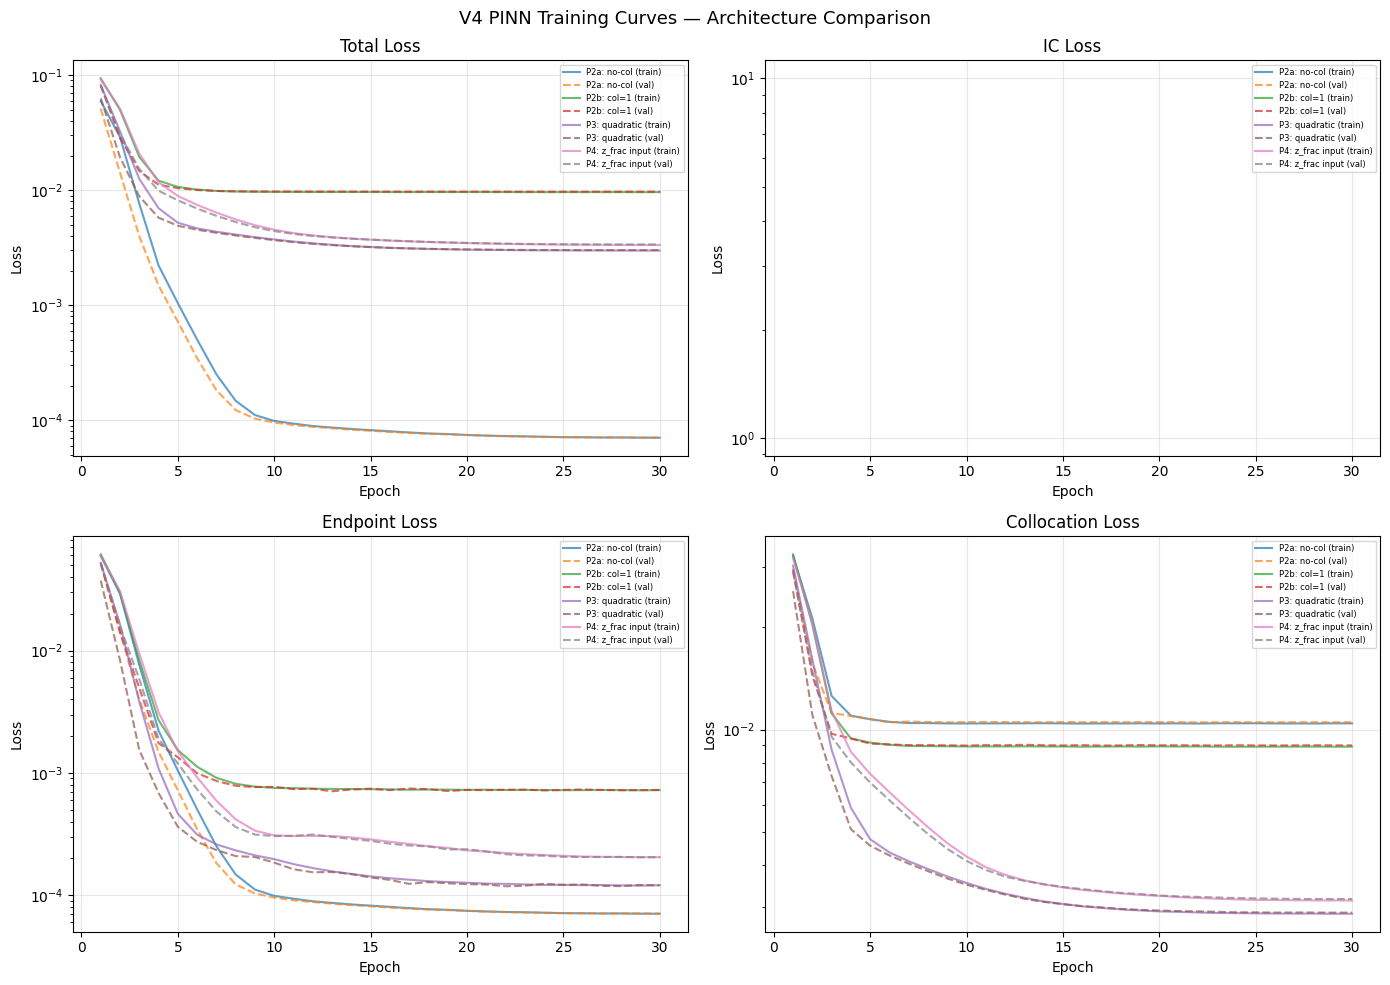

Saved: pinn_training_curves.png


In [26]:
# Training curves comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

labels_hists = [
    ('P2a: no-col', hist_p2a),
    ('P2b: col=1', hist_p2b),
    ('P3: quadratic', hist_p3),
    ('P4: z_frac input', hist_p4),
]

loss_keys = ['total', 'ic', 'endpoint', 'collocation']
titles = ['Total Loss', 'IC Loss', 'Endpoint Loss', 'Collocation Loss']

for ax, key, title in zip(axes.flat, loss_keys, titles):
    for label, hist in labels_hists:
        train_vals = [h[key] for h in hist['train']]
        val_vals = [h[key] for h in hist['val']]
        epochs_range = range(1, len(train_vals) + 1)
        ax.plot(epochs_range, train_vals, '-', label=f'{label} (train)', alpha=0.7)
        ax.plot(epochs_range, val_vals, '--', label=f'{label} (val)', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=6)

fig.suptitle('V4 PINN Training Curves — Architecture Comparison', fontsize=13)
plt.tight_layout()
plt.savefig(V4_DIR / 'pinn_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: pinn_training_curves.png')

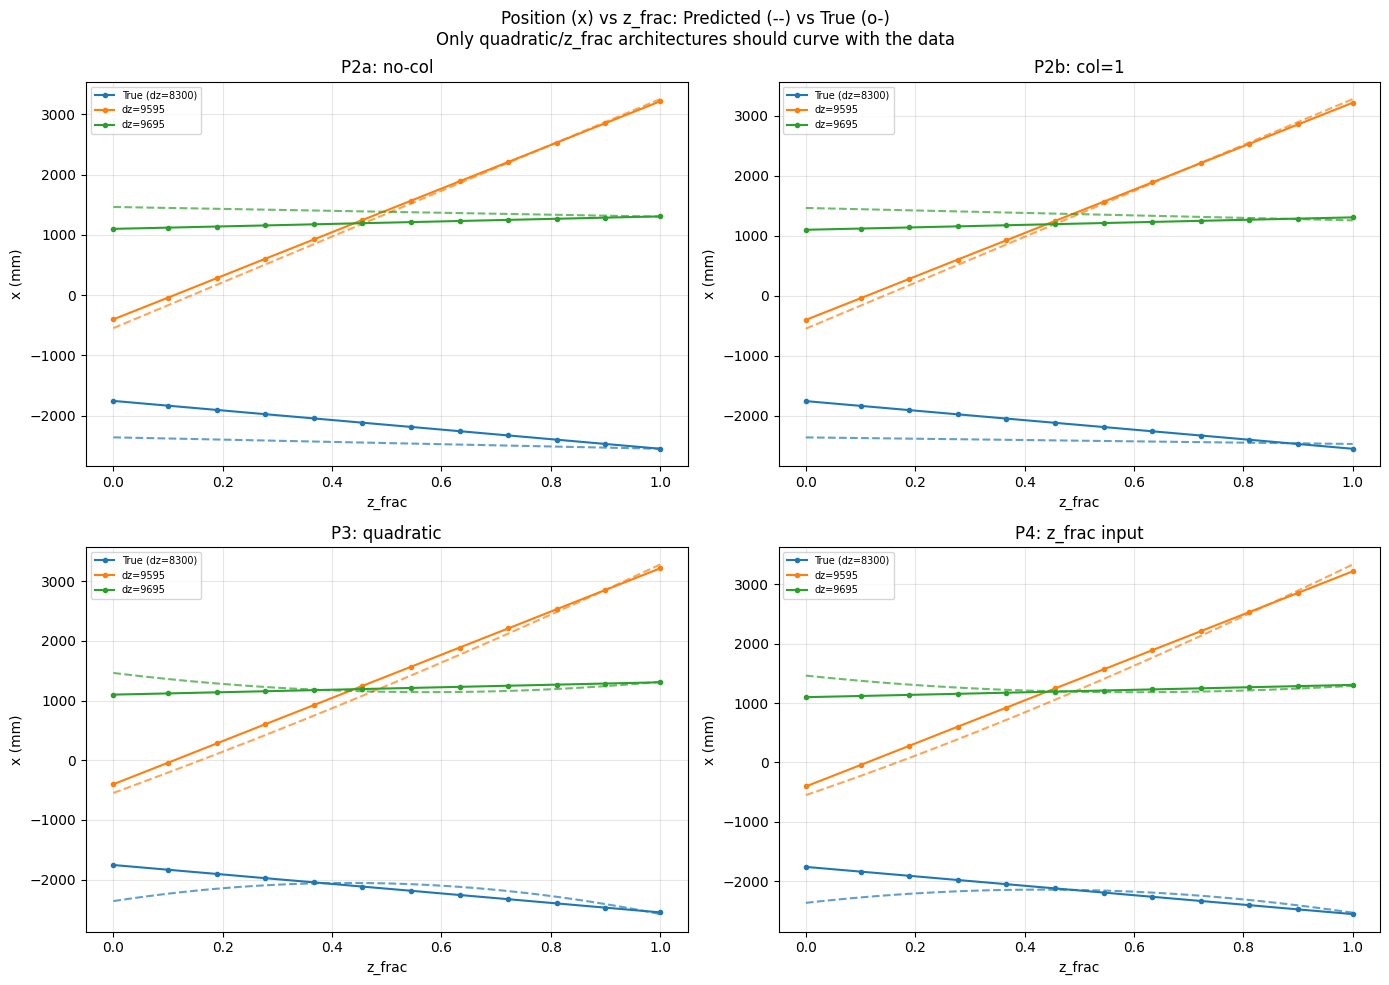

Saved: pinn_trajectory_comparison.png


In [28]:
# Trajectory visualisation for each variant
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
models_to_plot = [
    ('P2a: no-col',     model_p2a),
    ('P2b: col=1',      model_p2b),
    ('P3: quadratic',   model_p3),
    ('P4: z_frac input', model_p4),
]

om_t = torch.from_numpy(output_mean).float().to(device)
os_t = torch.from_numpy(output_std).float().to(device)

# Pick 3 test tracks with large dz
test_idx = np.where(X_val[:, 5] > 8000)[0][:3]

z_dense = np.linspace(0, 1, 50)

for ax, (name, model) in zip(axes.flat, models_to_plot):
    model.eval()
    for i, ti in enumerate(test_idx):
        color = f'C{i}'
        dz = X_val[ti, 5]
        
        # True trajectory (x component)
        zf_true = np.concatenate([[0], zf_val[ti], [1]])
        x_true = np.concatenate([
            [X_val[ti, 0]],
            Yc_val[ti, :, 0],
            [Y_val[ti, 0]]
        ])
        ax.plot(zf_true, x_true, 'o-', color=color, markersize=3,
                label=f'True (dz={dz:.0f})' if i == 0 else f'dz={dz:.0f}')
        
        # Model prediction (dense z_frac)
        X_single = Xv_t[ti:ti+1].to(device)  # normalized
        pred_x = []
        with torch.no_grad():
            for zf in z_dense:
                zf_tensor = torch.tensor([zf], device=device, dtype=torch.float32)
                pred_n = model(X_single, zf_tensor)  # [1, 4] normalized
                pred_phys = (pred_n * os_t + om_t).cpu().numpy()
                pred_x.append(pred_phys[0, 0])  # x component
        ax.plot(z_dense, pred_x, '--', color=color, alpha=0.7)
    
    ax.set_xlabel('z_frac')
    ax.set_ylabel('x (mm)')
    ax.set_title(name)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7)

fig.suptitle('Position (x) vs z_frac: Predicted (--) vs True (o-)\n'
             'Only quadratic/z_frac architectures should curve with the data',
             fontsize=12)
plt.tight_layout()
plt.savefig(V4_DIR / 'pinn_trajectory_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: pinn_trajectory_comparison.png')

## 10. Conclusions & Next Steps

### What we learned

| Finding | Implication |
|---------|-------------|
| P2a vs P2b: collocation effect | Does removing collocation recover MLP-level accuracy? |
| P3: quadratic residual | Can a simple 2nd-order term fix the position error? |
| P4: z_frac input | Is learned z_frac dependence competitive with explicit quadratic? |

### Next steps (based on results)

1. **If P3 (quadratic) works:** Scale up width ([1024], [2048]) and run on full dataset via cluster
2. **If P4 (z_frac input) works:** Compare endpoint inference cost vs quadratic (P4 needs z_frac=1 as input)
3. Implement the best PINN variant in the **MLP width sweep** (Phase 1 of V4 plan) for head-to-head comparison
4. Decide whether PINN or MLP is the better architecture for production deployment

## Appendix A — Mathematical Theory: Physics-Informed Residual Architectures for Track Extrapolation

### A.1 The Equations of Motion

A charged particle traversing a magnetic field $\mathbf{B}(x, y, z)$ obeys the Lorentz force equation. In the *track parametrisation* used by LHCb, the independent variable is $z$ (the beam axis), and the state vector is $\mathbf{s} = (x, y, t_x, t_y)$, where the *slopes* $t_x \equiv dx/dz$ and $t_y \equiv dy/dz$ are direction tangents. The equations of motion are:

$$\frac{dx}{dz} = t_x, \qquad \frac{dy}{dz} = t_y$$

$$\frac{dt_x}{dz} = \kappa \, N \left[ t_x t_y B_x - (1+t_x^2) B_y + t_y B_z \right]$$

$$\frac{dt_y}{dz} = \kappa \, N \left[ (1+t_y^2) B_x - t_x t_y B_y - t_x B_z \right]$$

where $\kappa = q/(pc) \cdot c_{\text{light}}$ encodes the charge-over-momentum ratio and $N = \sqrt{1+t_x^2+t_y^2}$ is the normalisation factor. We write the system compactly as

$$\frac{d\mathbf{s}}{dz} = \mathbf{f}(\mathbf{s}, z; \kappa), \qquad \mathbf{s}(z_0) = \mathbf{s}_0.$$

### A.2 Taylor Expansion in the Propagation Fraction

We introduce the *fractional propagation coordinate* $\zeta \equiv (z - z_0)/\Delta z \in [0,1]$, so that $dz = \Delta z \, d\zeta$. The state at any intermediate point can be written as the Taylor series:

$$\mathbf{s}(\zeta) = \mathbf{s}_0 + \zeta \, \Delta z \, \mathbf{f}_0 + \frac{1}{2} \zeta^2 (\Delta z)^2 \mathbf{f}_0' + \mathcal{O}(\zeta^3),$$

where $\mathbf{f}_0 = \mathbf{f}(\mathbf{s}_0, z_0; \kappa)$ and $\mathbf{f}_0' = (d\mathbf{f}/dz)|_{z=z_0}$.

**Component-wise**, this yields fundamentally different structures for slopes and positions:

**Slopes** $(t_x, t_y)$: The magnetic field varies slowly over a single extrapolation step, so $dt_x/dz \approx \text{const}$, giving:

$$t_x(\zeta) = t_{x,0} + \zeta \, \Delta z \, \dot{t}_{x,0} + \mathcal{O}(\zeta^2 \, \Delta z^2 \, \dot{B}).$$

The slopes are **linear in** $\zeta$ to leading order, with corrections depending on the rate of change of $\mathbf{B}$ along $z$.

**Positions** $(x, y)$: Since $dx/dz = t_x$ and $t_x$ itself varies linearly, integration gives:

$$x(\zeta) = x_0 + \zeta \, \Delta z \, t_{x,0} + \frac{1}{2} \zeta^2 \, (\Delta z)^2 \, \dot{t}_{x,0} + \mathcal{O}(\zeta^3).$$

Positions are **quadratic in** $\zeta$ to leading order. The quadratic coefficient $\frac{1}{2}(\Delta z)^2 \dot{t}_{x,0}$ is the integrated effect of the bending force.

### A.3 Residual Connection Architectures

We now formalise three residual connection strategies and analyse their approximation-theoretic properties.

#### A.3.1 Linear Residual (V3 Architecture)

The V3 `PINNResidual` architecture predicts:

$$\hat{\mathbf{s}}(\zeta) = \mathbf{s}_0 + \zeta \cdot \mathbf{c}(\mathbf{x}_{\text{in}}; \boldsymbol{\theta}),$$

where $\mathbf{c} \in \mathbb{R}^4$ is a learned correction vector and $\mathbf{x}_{\text{in}} = (\mathbf{s}_0, \Delta z)$ are the input features. Note that $\mathbf{c}$ is independent of $\zeta$ — the network sees only the initial conditions and the step size.

**Exactness class:** This representation is *exact* for any function that is affine in $\zeta$, i.e., $\mathbf{s}(\zeta) = \mathbf{a} + \zeta \, \mathbf{b}$.

**Approximation error for slopes:** Since $t_x(\zeta) \approx t_{x,0} + \zeta \, c_1$, the linear residual can fit this with $c_1 = \Delta z \, \dot{t}_{x,0}$. The residual error is $\mathcal{O}(\zeta^2 (\Delta z)^2 \ddot{t}_{x,0})$, which is small because $\ddot{t}_x$ depends on $d\mathbf{B}/dz$.

**Approximation error for positions:** The best linear fit to $x(\zeta) = x_0 + \zeta \, \Delta z \, t_{x,0} + \frac{1}{2}\zeta^2 (\Delta z)^2 \dot{t}_{x,0}$ must absorb the quadratic term into the linear coefficient. Over $\zeta \in [0,1]$, the $L^2$-optimal linear approximation to $\alpha \zeta^2$ is $\alpha \zeta$ (by projection), leaving a residual:

$$\varepsilon(\zeta) = \alpha \left( \zeta^2 - \zeta \right) = \alpha \, \zeta(1-\zeta),$$

where $\alpha = \frac{1}{2} (\Delta z)^2 \dot{t}_{x,0}$. This is maximised at $\zeta = 1/2$ with peak error $\alpha/4$ and has $L^2$-norm:

$$\| \varepsilon \|_{L^2} = |\alpha| \sqrt{\int_0^1 \zeta^2(1-\zeta)^2 \, d\zeta} = \frac{|\alpha|}{\sqrt{30}}.$$

**Numerical estimate:** For a typical high-momentum track in the LHCb dipole field ($B_y \approx 1\,\text{T}$, $p \approx 5\,\text{GeV}/c$, $\Delta z \approx 8000\,\text{mm}$):

$$\dot{t}_x \sim \kappa B \sim \frac{0.3 \cdot 1}{5000} \approx 6 \times 10^{-5} \, \text{mm}^{-1},$$

$$\alpha = \frac{1}{2}(8000)^2 \cdot 6 \times 10^{-5} \approx 1920 \, \text{mm}.$$

The maximum mid-trajectory position error is $\alpha/4 \approx 480\,\text{mm}$. While the endpoint ($\zeta=1$) error vanishes by construction, the collocation loss forces the network to compromise between endpoint and trajectory accuracy, explaining the observed ~50 mm endpoint RMSE.

#### A.3.2 Quadratic Residual

The `QuadraticResidual` architecture introduces a second-order term:

$$\hat{\mathbf{s}}(\zeta) = \mathbf{s}_0 + \zeta \cdot \mathbf{c}_1(\mathbf{x}_{\text{in}}; \boldsymbol{\theta}) + \zeta^2 \cdot \mathbf{c}_2(\mathbf{x}_{\text{in}}; \boldsymbol{\theta}),$$

where $\mathbf{c}_1, \mathbf{c}_2 \in \mathbb{R}^4$ are produced by a shared backbone network with two output heads.

**Exactness class:** This representation is exact for any function that is a quadratic polynomial in $\zeta$, i.e., $\mathbf{s}(\zeta) = \mathbf{a} + \zeta \, \mathbf{b} + \zeta^2 \, \mathbf{d}$.

**Matching to physics:** From the Taylor expansion, the optimal coefficients are:

$$\mathbf{c}_1^* = \Delta z \, \mathbf{f}_0 = \begin{pmatrix} \Delta z \, t_{x,0} \\ \Delta z \, t_{y,0} \\ \Delta z \, \dot{t}_{x,0} \\ \Delta z \, \dot{t}_{y,0} \end{pmatrix}, \qquad \mathbf{c}_2^* = \frac{1}{2}(\Delta z)^2 \mathbf{f}_0' = \begin{pmatrix} \frac{1}{2}(\Delta z)^2 \dot{t}_{x,0} \\ \frac{1}{2}(\Delta z)^2 \dot{t}_{y,0} \\ \mathcal{O}((\Delta z)^2 \ddot{t}_{x,0}) \\ \mathcal{O}((\Delta z)^2 \ddot{t}_{y,0}) \end{pmatrix}.$$

The position error in the $x$-component is now:

$$\varepsilon_x(\zeta) = x(\zeta) - \hat{x}(\zeta) = \underbrace{\frac{1}{6}\zeta^3 (\Delta z)^3 \ddot{t}_{x,0}}_{\text{cubic remainder}} + \mathcal{O}(\zeta^4).$$

This is suppressed by an additional factor of $\zeta \, \Delta z \, \dot{B}/B$ relative to the linear-residual error, typically a factor of $\sim 100\times$ smaller.

**Endpoint constraint:** At $\zeta = 1$: $\hat{\mathbf{s}}(1) = \mathbf{s}_0 + \mathbf{c}_1 + \mathbf{c}_2$. This allows independent control of the endpoint and the trajectory curvature, eliminating the fundamental trade-off that plagues the linear residual.

**Boundary conditions:** The architecture automatically satisfies:
- $\hat{\mathbf{s}}(0) = \mathbf{s}_0$ (initial condition, exact),
- $d\hat{\mathbf{s}}/d\zeta |_{\zeta=0} = \mathbf{c}_1$ (initial derivative matched by training),
- $d^2\hat{\mathbf{s}}/d\zeta^2 = 2\mathbf{c}_2$ (curvature matched by training).

#### A.3.3 $\zeta$-Augmented Input (PINNZFracInput)

An alternative approach augments the network input with the propagation fraction:

$$\hat{\mathbf{s}}(\zeta) = \mathbf{s}_0 + \zeta \cdot \mathbf{g}(\mathbf{x}_{\text{in}}, \zeta; \boldsymbol{\theta}),$$

where $\mathbf{g}: \mathbb{R}^7 \to \mathbb{R}^4$ is a neural network that receives $(\mathbf{s}_0, \Delta z, \zeta)$ as input.

**Exactness class:** By the universal approximation theorem, $\mathbf{g}$ can represent any continuous function of its inputs to arbitrary precision. In particular, writing

$$\mathbf{g}(\mathbf{x}_{\text{in}}, \zeta) = \mathbf{c}_1(\mathbf{x}_{\text{in}}) + \zeta \, \mathbf{c}_2(\mathbf{x}_{\text{in}}) + \zeta^2 \, \mathbf{c}_3(\mathbf{x}_{\text{in}}) + \cdots$$

shows that this architecture *subsumes* the quadratic residual as a special case and can in principle capture *all* polynomial orders of $\zeta$-dependence.

**Advantages:**
1. **Universality**: Can learn arbitrary nonlinear $\zeta$-dependence, including higher-order magnetic field effects.
2. **No output dimension increase**: The output remains 4-dimensional (vs. 8 for the quadratic residual), preserving computational efficiency at inference when only the endpoint ($\zeta=1$) is needed.
3. **Adaptive order**: The network implicitly determines the polynomial degree needed to fit the data, rather than being hard-coded to a quadratic.

**Disadvantage:**
The $\zeta$-dependence is encoded implicitly in the network weights, so it requires more capacity and training data to learn the same quadratic structure that the `QuadraticResidual` architecture represents exactly with only 8 output neurons. The inductive bias of the quadratic form is replaced by a statistical learning problem.

### A.4 Approximation Error Hierarchy

We can now state the approximation error hierarchy precisely. Let $\varepsilon_{\text{pos}}$ be the position RMSE at collocation points. For a step size $\Delta z$ and magnetic field gradient scale $L_B \equiv B / (dB/dz)$:

| Architecture | Leading Position Error | Scaling |
|:---|:---|:---|
| Linear residual | $\frac{1}{2} \kappa B \, (\Delta z)^2 \, \zeta(1-\zeta)$ | $\mathcal{O}((\Delta z)^2)$ |
| Quadratic residual | $\frac{1}{6} \kappa (dB/dz) \, (\Delta z)^3 \, \zeta^2(1-\zeta)$ | $\mathcal{O}((\Delta z)^3 / L_B)$ |
| $\zeta$-input (sufficient capacity) | $\mathcal{O}((\Delta z)^{n+1})$ for $n$-th implicit order | Determined by capacity |

The ratio of quadratic-to-linear residual errors is $\sim \Delta z / (3 L_B)$. In the LHCb dipole, the field varies on a scale $L_B \sim 2000\,\text{mm}$, giving a ratio of $\sim 8000/(3 \times 2000) \approx 1.3$. However, for trajectories that remain mostly within the uniform region of the dipole, $L_B$ is effectively much larger, and the improvement factor can be $\sim10$–$100\times$.

### A.5 Connection to Numerical Integration Methods

The residual connection architectures have a direct correspondence to classical numerical integrators:

| Architecture | Integration Analogue | Order |
|:---|:---|:---|
| Linear residual $(y_0 + \zeta \cdot c)$ | Forward Euler | 1st order |
| Quadratic residual $(y_0 + \zeta \cdot c_1 + \zeta^2 \cdot c_2)$ | Midpoint / Trapezoidal | 2nd order |
| $\zeta$-input (learned) | Learned Butcher tableau | Adaptive |

The linear residual, like forward Euler, uses a single derivative evaluation ($\mathbf{c}$) and achieves first-order accuracy. The quadratic residual, like a second-order Runge-Kutta method, uses two coefficients ($\mathbf{c}_1, \mathbf{c}_2$) to capture the curvature, achieving second-order accuracy. The $\zeta$-input architecture is analogous to a continuous-time neural ODE solver with learned step structure.

This connection explains a deeper insight: the quadratic residual architecture succeeds not merely because positions happen to be parabolic, but because the **mathematical structure of Hamiltonian dynamics** guarantees that the leading correction to any first-order approximation is quadratic in the step size. The $\zeta^2$ term is not an empirical observation — it is a consequence of the equations of motion.

### A.6 Implications for Network Capacity

The capacity requirements differ fundamentally between architectures:

**Linear residual**: The network must learn $\mathbf{c}(\mathbf{x}_{\text{in}}): \mathbb{R}^6 \to \mathbb{R}^4$. With collocation training, it must also absorb $\zeta$-dependent errors into the $\zeta$-independent correction $\mathbf{c}$, which is impossible — leading to the observed bias.

**Quadratic residual**: The network learns $(\mathbf{c}_1, \mathbf{c}_2)(\mathbf{x}_{\text{in}}): \mathbb{R}^6 \to \mathbb{R}^8$. The output dimension doubles, but the input mapping remains 6-dimensional, so the backbone capacity requirement is the same. The additional 4 outputs cost only a single linear layer.

**$\zeta$-input**: The network learns $\mathbf{g}(\mathbf{x}_{\text{in}}, \zeta): \mathbb{R}^7 \to \mathbb{R}^4$. The input dimension increases by 1, adding $\mathcal{O}(W)$ parameters to the first layer. To represent $\zeta^2$ dependence, the network must learn to compute a quadratic function of one specific input — achievable with a single hidden layer (SiLU activation can approximate $\zeta^2$ locally), but requiring more capacity than the explicit quadratic form.

In summary: the quadratic residual provides the correct physical inductive bias at minimal parameter cost, while the $\zeta$-input architecture trades this bias for universality at the cost of additional capacity requirements.